INTRODUTION:- Predicting the Silent Threat: A Machine Learning Approach to Heart Attack Risk Assessment

Heart attacks claim millions of lives globally, often striking with devastating suddenness. This project aims to leverage the power of machine learning to predict the risk of heart attacks, potentially saving lives through early intervention and preventive measures.We will embark on a journey to build a robust prediction model, utilizing data encompassing traditional risk factors like blood pressure, cholesterol,  fasting blood sugar ,and various other parameters. Cutting-edge machine learning algorithms will analyze this wealth of information, identifying hidden patterns and relationships that can shed light on individual susceptibility to heart attacks.Our goal is to create a user-friendly tool that empowers individuals to understand their personal risk profile. This tool will not only provide a risk score but also offer tailored recommendations for lifestyle changes and preventative actions, promoting proactive health management.






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter


In [2]:
from tqdm.auto import tqdm
import math
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


In [3]:

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc


from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


In [4]:
def describe(df):
 
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing_#'] = df.isnull().sum().values 
    summ['missing_%'] = df.isnull().sum().values / len(df) * 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['min'] = desc['min'].values
    summ['25%'] = desc['25%'].values
    summ['50%'] = desc['50%'].values
    summ['75%'] = desc['75%'].values
    summ['max'] = desc['max'].values
    summ['1st'] = df.loc[0].values
    summ['2nd'] = df.loc[1].values
    summ['3rd'] = df.loc[2].values
    
    return summ


In [5]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    f, ax = plt.subplots(len(col_list), 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    for col in col_list:
        s1 = df[col].value_counts()
        N = len(s1)
        outer_sizes = s1
        inner_sizes = s1/N
        outer_colors = ['#FF6347', '#20B2AA']
        inner_colors = ['#FFA07A', '#40E0D0']

        ax[0].pie(
            outer_sizes, colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.2, 
            explode=([0.05]*(N-1) + [.2]),
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, 
            textprops={'fontsize': 14, 'weight': 'bold'},
            shadow=True
        )

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=0.8, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.2]),
            pctdistance=0.8, textprops={'size': 13, 'weight': 'bold', 'color': 'black'},
            shadow=True
        )

        center_circle = plt.Circle((0,0), .5, color='black', fc='white', linewidth=0)
        ax[0].add_artist(center_circle)
        sns.barplot(
            x=s1, y=s1.index, ax=ax[1],
            palette='coolwarm', orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax[1].set_ylabel('')  # Remove y label
        ax[1].bar_label(ax[1].containers[0], color='black', fontweight='bold', fontsize=14)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='black', fontsize=14)

    f.suptitle(f'{title_name} Dataset Distribution of {col}', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()    
    plt.show()

In [6]:
def plot_dist(df: pd.core.frame.DataFrame, col_list: list, target: str, title_name: str='Train') -> None:
    f, ax = plt.subplots(len(col_list), 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    for col in col_list:
        ax[0] = sns.histplot(x=col, hue=target, data=df, bins=30, kde=True, palette='Reds')
        ax[1] = sns.boxplot(x=target, y=col, data=data)

    f.suptitle(f'{title_name} Dataset Distribution of {col}', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()    
    plt.show()

In [7]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, order:str='target', title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True, annot_kws={"size": 8})
    plt.title(title_name, fontsize=20, fontweight='bold', y=1.05)
    plt.show()

# LOADING DATA 

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/ARINBHAI/Heart-Attack-Prediction---1/main/heart.csv")
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# EXPLORATORY DATA ANALYSIS

In [9]:
describe(data)

,data type,missing_#,missing_%,unique,mean,std,min,25%,50%,75%,max,1st,2nd,3rd
age,int64,0,0.0,41,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0,63.0,37.0,41.0
sex,int64,0,0.0,2,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
cp,int64,0,0.0,4,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0,3.0,2.0,1.0
trtbps,int64,0,0.0,49,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0,145.0,130.0,130.0
chol,int64,0,0.0,152,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0,233.0,250.0,204.0
fbs,int64,0,0.0,2,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
restecg,int64,0,0.0,3,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0
thalachh,int64,0,0.0,91,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0,150.0,187.0,172.0
exng,int64,0,0.0,2,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
oldpeak,float64,0,0.0,40,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2,2.3,3.5,1.4


                                                DATA SUMMARY:-


*Total Number of Variables: 14

*Data Types:
Float64: 1 (oldpeak)
Int64: 13 (All other variables including the target 'output')

*Missing Values: None (All variables have 0 missing values)

*Target Variable: 'output' (Binary: 0 or 1)

                                                  FEATURES OVERVIEW:-
                                              
*Age: Patient's age.

*Sex: Patient's gender.

*Chest Pain (cp): 1=Typical, 2=Atypical, 3=Non-anginal, 4=Asymptomatic.

*Resting BP (trtbps): Resting blood pressure in mm Hg.

*Choesterol (chol): Cholesterol level in mg/dl.

*Fasting Sugar (fbs): True if >120 mg/dl.

*Resting ECG (restecg): 0=Normal, 1=ST-T abnormalities, 2=LV hypertrophy.

*Max Heart Rate (thalachh): Maximum heart rate achieved.

*Exercise Angina (exng): 1=Yes, 0=No.

*Oldpeak: Previous peak.

*Slope (slp)

*Vessels (caa): Number of major vessels (0-3).

*Thal Rate (thall)

*Output: 1=Higher chance, 0=Lower chance of a heart attack.


                                                        NOTE:-

*There are no missing values in the dataset, so you don't have to consider imputation methods.

*The target variable is 'output' which is binary. This indicates whether the individual has a higher or lesser chance of heart attack.

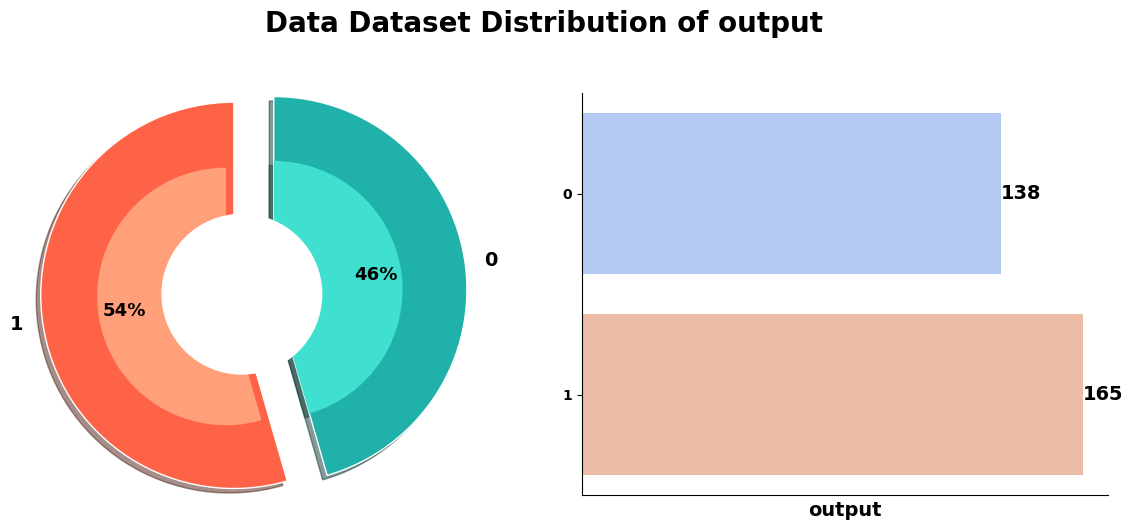

In [10]:
plot_count(data, ['output'], 'Data')

                                            TARGET VALUE DISTRIBUTION:-

The heart attack dataset shows that there are 165 instances labeled as 0 and 138 instances labeled as 1. It's like having more of one group than the other, but not by a lot.Even though it's not a big difference0, we need to think about it when we're training the model to predict heart attacks. We want the model to be good at predicting both situations, not just the more common one. So, when we're training the model, we should keep this difference in mind. 

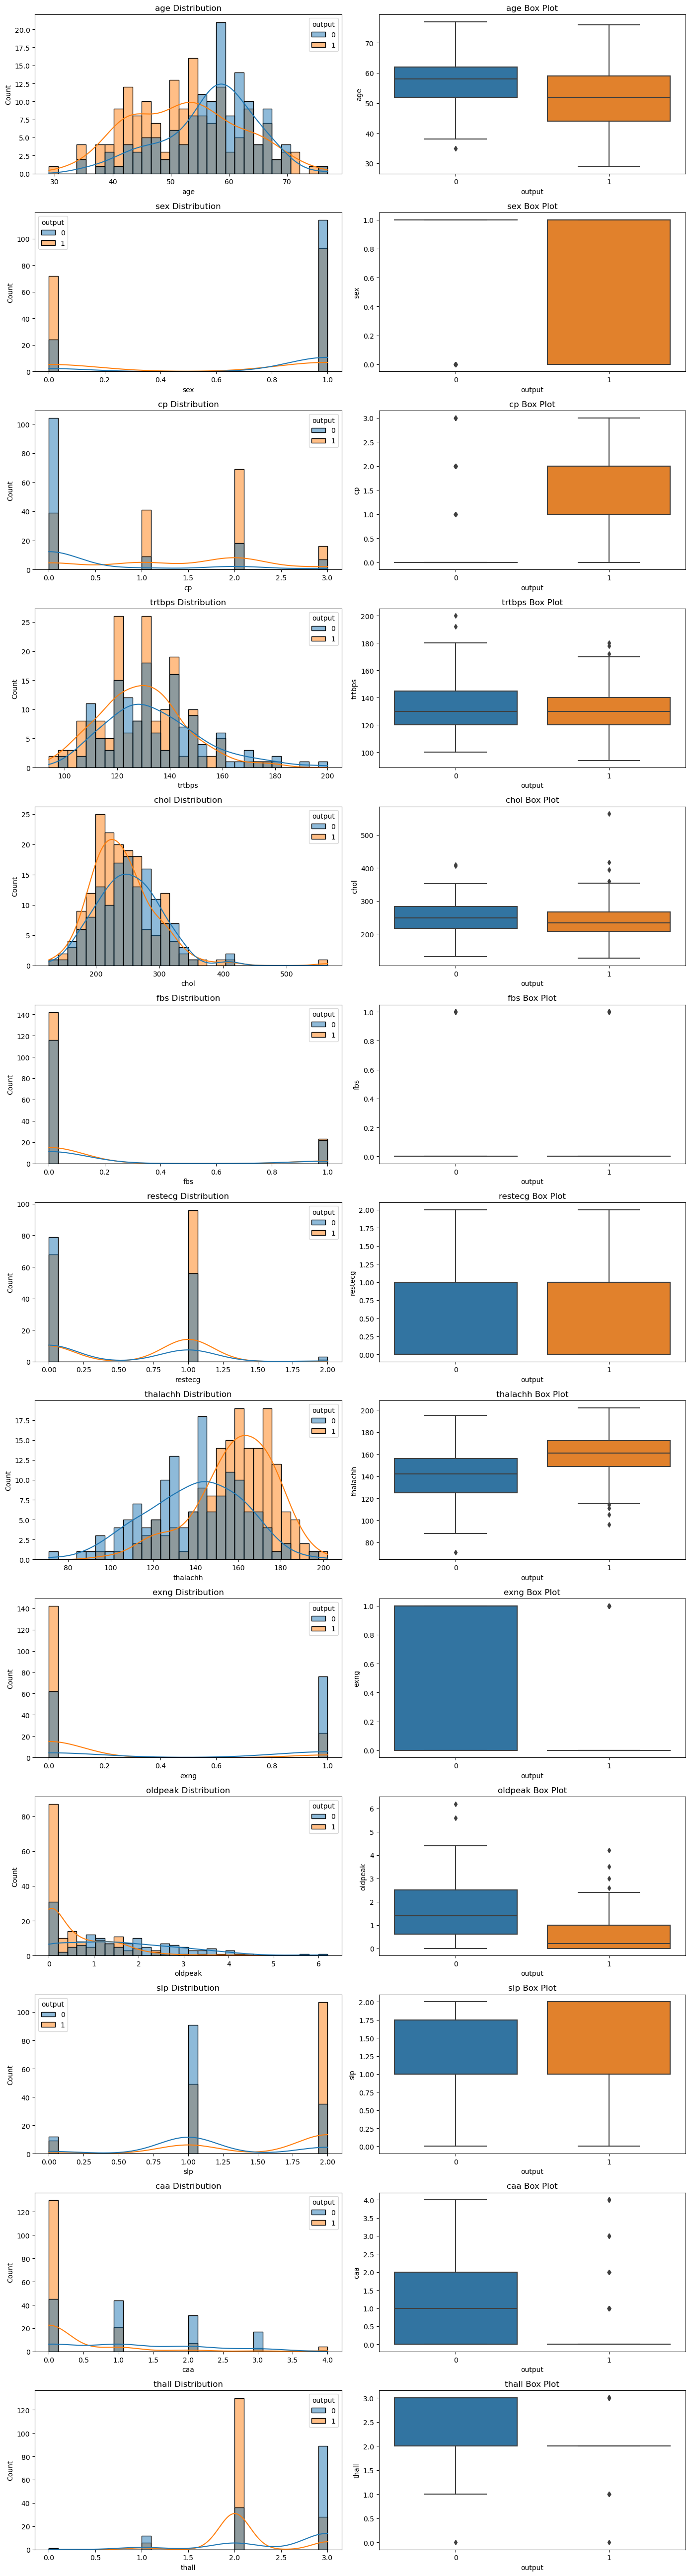

In [11]:
num_variables = data.select_dtypes(include=[np.number]).columns.tolist()
num_variables.remove('output')

fig, ax = plt.subplots(len(num_variables), 2, figsize=(14, len(num_variables)*4))

for idx, column in enumerate(num_variables):
    sns.histplot(x=column, hue="output", data=data, bins=30, kde=True,ax=ax[idx,0])
    ax[idx,0].set_title(f"{column} Distribution")
    
    sns.boxplot(x='output', y=column, data=data, ax=ax[idx,1])
    ax[idx,1].set_title(f"{column} Box Plot")
    
plt.tight_layout() 
plt.show()

                                           NUMERICAL VALUES DISTRIBUTION:-


*In our dataset, we have only five columns that contain numerical values—age, blood pressure (trtbps), cholesterol (chol), maximum heart rate (thalachh), and a measure of ST depression induced by exercise (oldpeak). The remaining eight columns are categorical and have been label-encoded.

*Examining the numerical columns, we observe that, except for age, there is either a leftward or rightward skewness present in the data distribution. Skewness essentially indicates whether the values are evenly spread or tend to concentrate on one side. In this case, we notice that the distribution is not balanced for most numerical features.

*To address this, we aim to mitigate the skewness during the process of feature engineering. This step is crucial as it contributes to unbiased statistical analyses and fosters accuracy in predictive modeling. The goal is to normalize the distribution of data, enhancing its normality and aligning with key statistical assumptions. Essentially, we are refining the data to ensure more reliable and robust insights when building models for predicting heart attacks.

                                                    OUTLIERS:-
                                                    
*The boxplot analysis shows that there are a few unusual data points in our dataset, known as outliers. Outliers are values that stand out a lot from the rest and can mess up our statistical analyses and predictions. It's important to spot and deal with outliers to make sure our data analysis is reliable and accurate.

*These outliers can mess with how the data is spread out, where the middle is, and how much it varies. This messing around could give us results that are not quite right. So, we need to use smart methods to handle these outliers, like removing them, changing them in some way, or using special statistical techniques that can handle them better. It's all about making sure our data plays nice and gives us trustworthy results.                                                
                                                    

C:\Users\panse\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\panse\AppData\Local\Temp\ipykernel_112008\3629503687.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


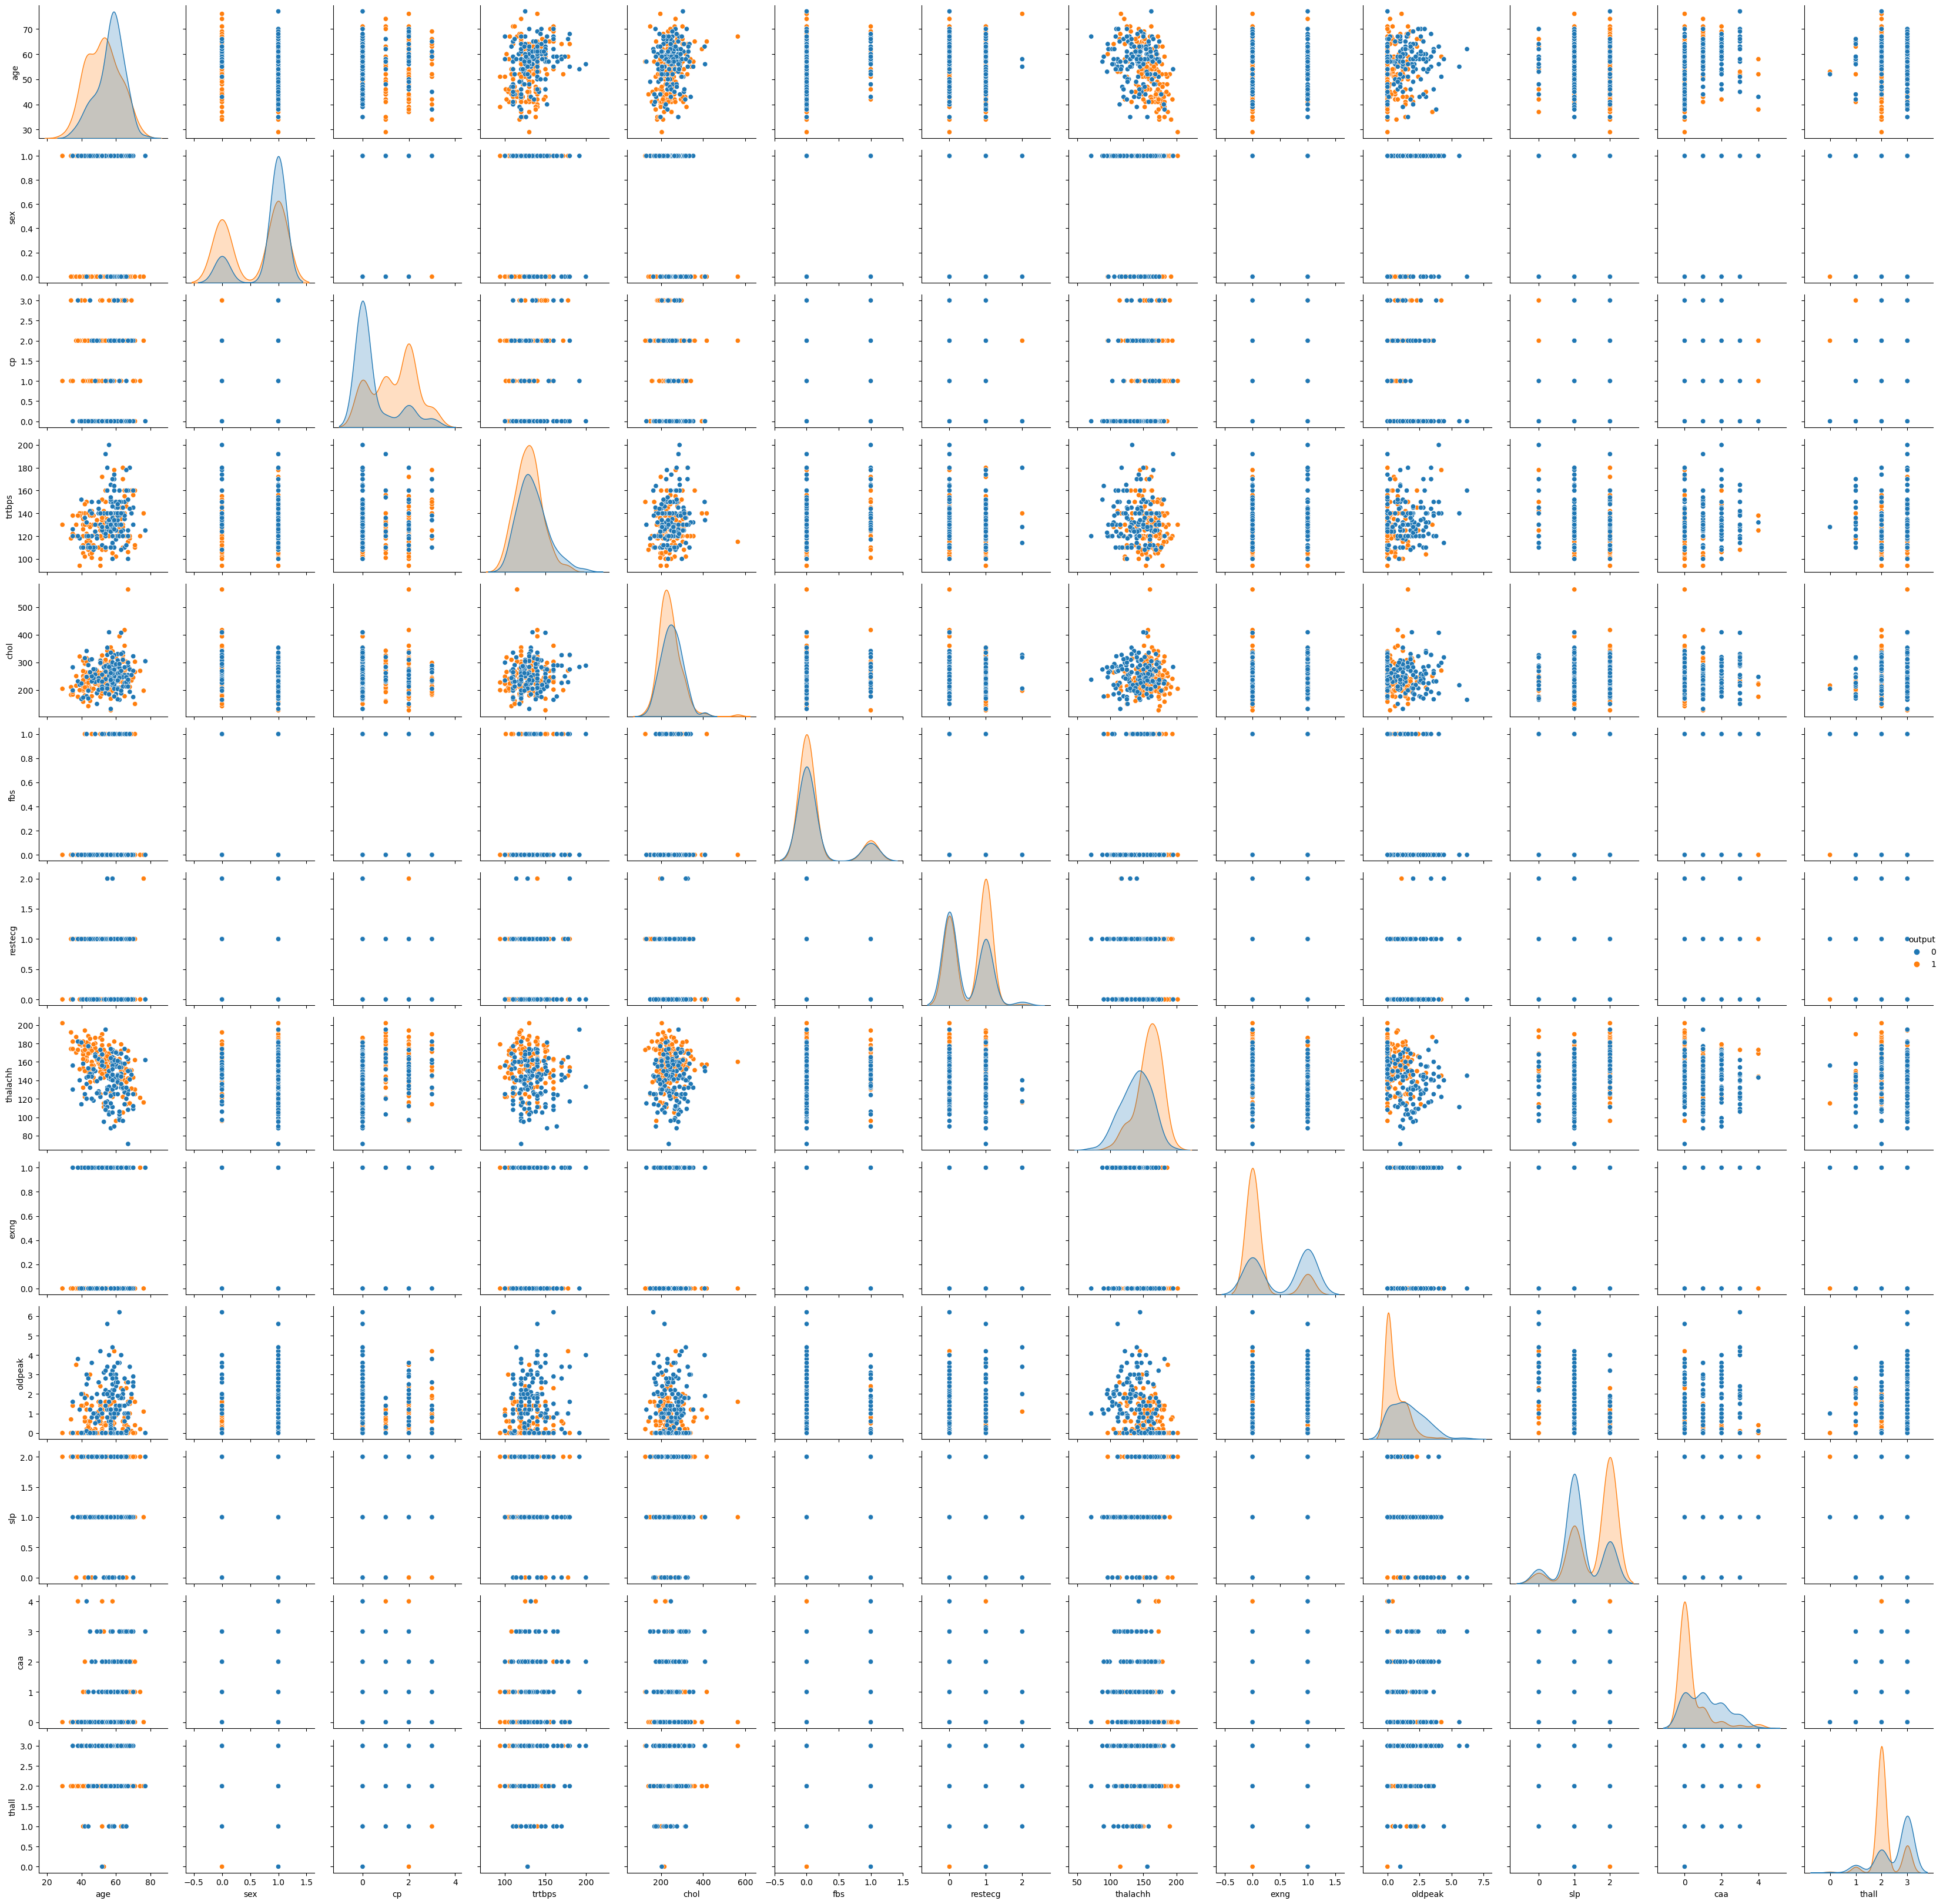

In [12]:
sns.pairplot(data, hue='output')
plt.tight_layout()
plt.show()

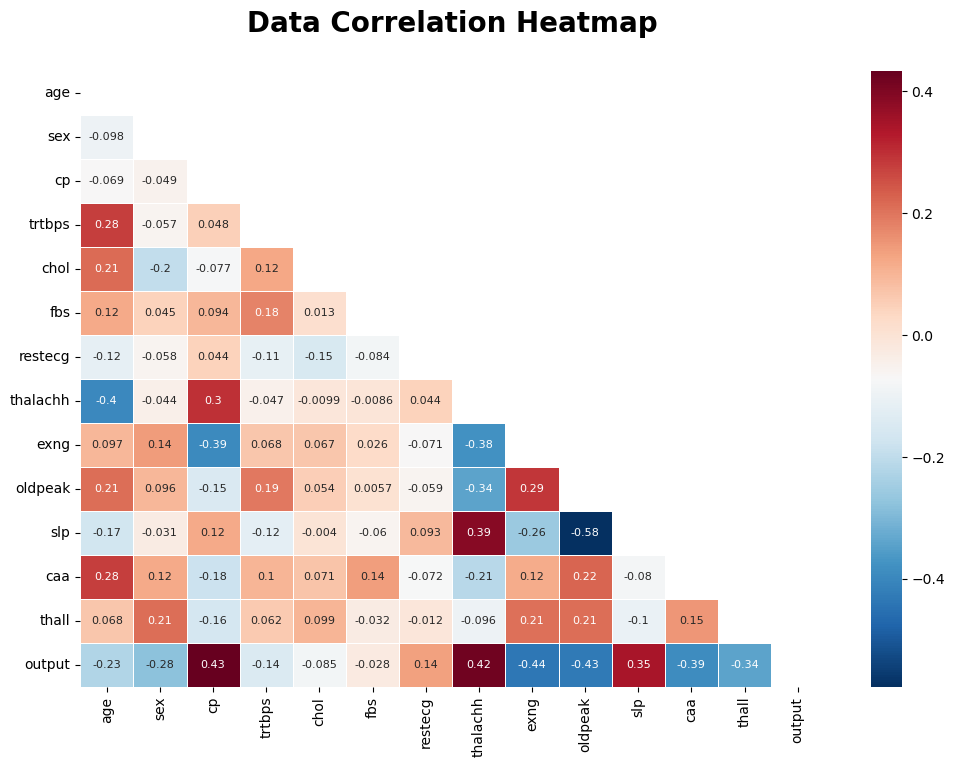

In [13]:
plot_correlation_heatmap(data, 'output', 'Data Correlation Heatmap')

                                            CORRELATION ANALYSIS:-


*Age and Health Indicators:
Age is moderately correlated with elevated cholesterol and resting blood pressure. This implies that advancing age may be associated with higher levels of these health indicators.

*Gender and Heart Disease:
Gender does not exhibit significant correlations with most health features. This suggests that gender may not play a    pivotal role in determining the likelihood of heart disease within this dataset.

*Chest Pain as an Indicator:
The presence of chest pain (cp) demonstrates a strong positive correlation with the likelihood of heart disease. This signifies that chest pain may serve as a significant indicator of the presence of heart disease.

*Blood Pressure and Cholesterol:
Resting blood pressure and cholesterol levels display weak correlations with other features. This suggests that these parameters may not serve as robust indicators of heart disease within this dataset.

*Fasting Blood Sugar Influence:
Fasting blood sugar (fbs) does not show significant correlations with other features, indicating that it may not exert substantial influence on the presence of heart disease.

*Electrocardiographic Results and Thallium Stress Tests:
Resting electrocardiographic results (restecg) and thallium stress tests (thall) exhibit mild correlations with certain features, suggesting a marginal role in predicting heart disease.

*Maximum Heart Rate:
Maximum heart rate (thalachh) demonstrates a moderate negative correlation with age and a moderate positive correlation with the likelihood of heart disease. This implies that lower maximum heart rates may be associated with increased age and a higher likelihood of heart disease.

*Exercise-Induced Angina:
The presence of exercise-induced angina (exng) displays a moderate negative correlation with chest pain and a moderate positive correlation with the likelihood of heart disease. This suggests that the absence of exercise-induced angina may indicate a higher likelihood of heart disease.

*ST Depression and Slope:
Strong correlations between oldpeak and slope suggest a close relationship between the extent of ST depression induced by exercise and the slope of the peak exercise ST segment.

*Number of Major Vessels:
The number of major vessels (caa) exhibits mild correlations with certain features, indicating a moderate role in predicting heart disease.

*Target Variable:
The target variable (output) demonstrates a strong positive correlation with chest pain and a moderate negative correlation with the absence of exercise-induced angina. This underscores their significance in predicting the likelihood of heart disease.

# FEATURE ENGINEERING 

In [14]:
df = data.copy()
num_cols = ['age','trtbps','thalachh','oldpeak']
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']

df = pd.get_dummies(df,columns = cat_cols,drop_first = True)
X = df.drop(['output'],axis = 1)
y = df[['output']]

scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

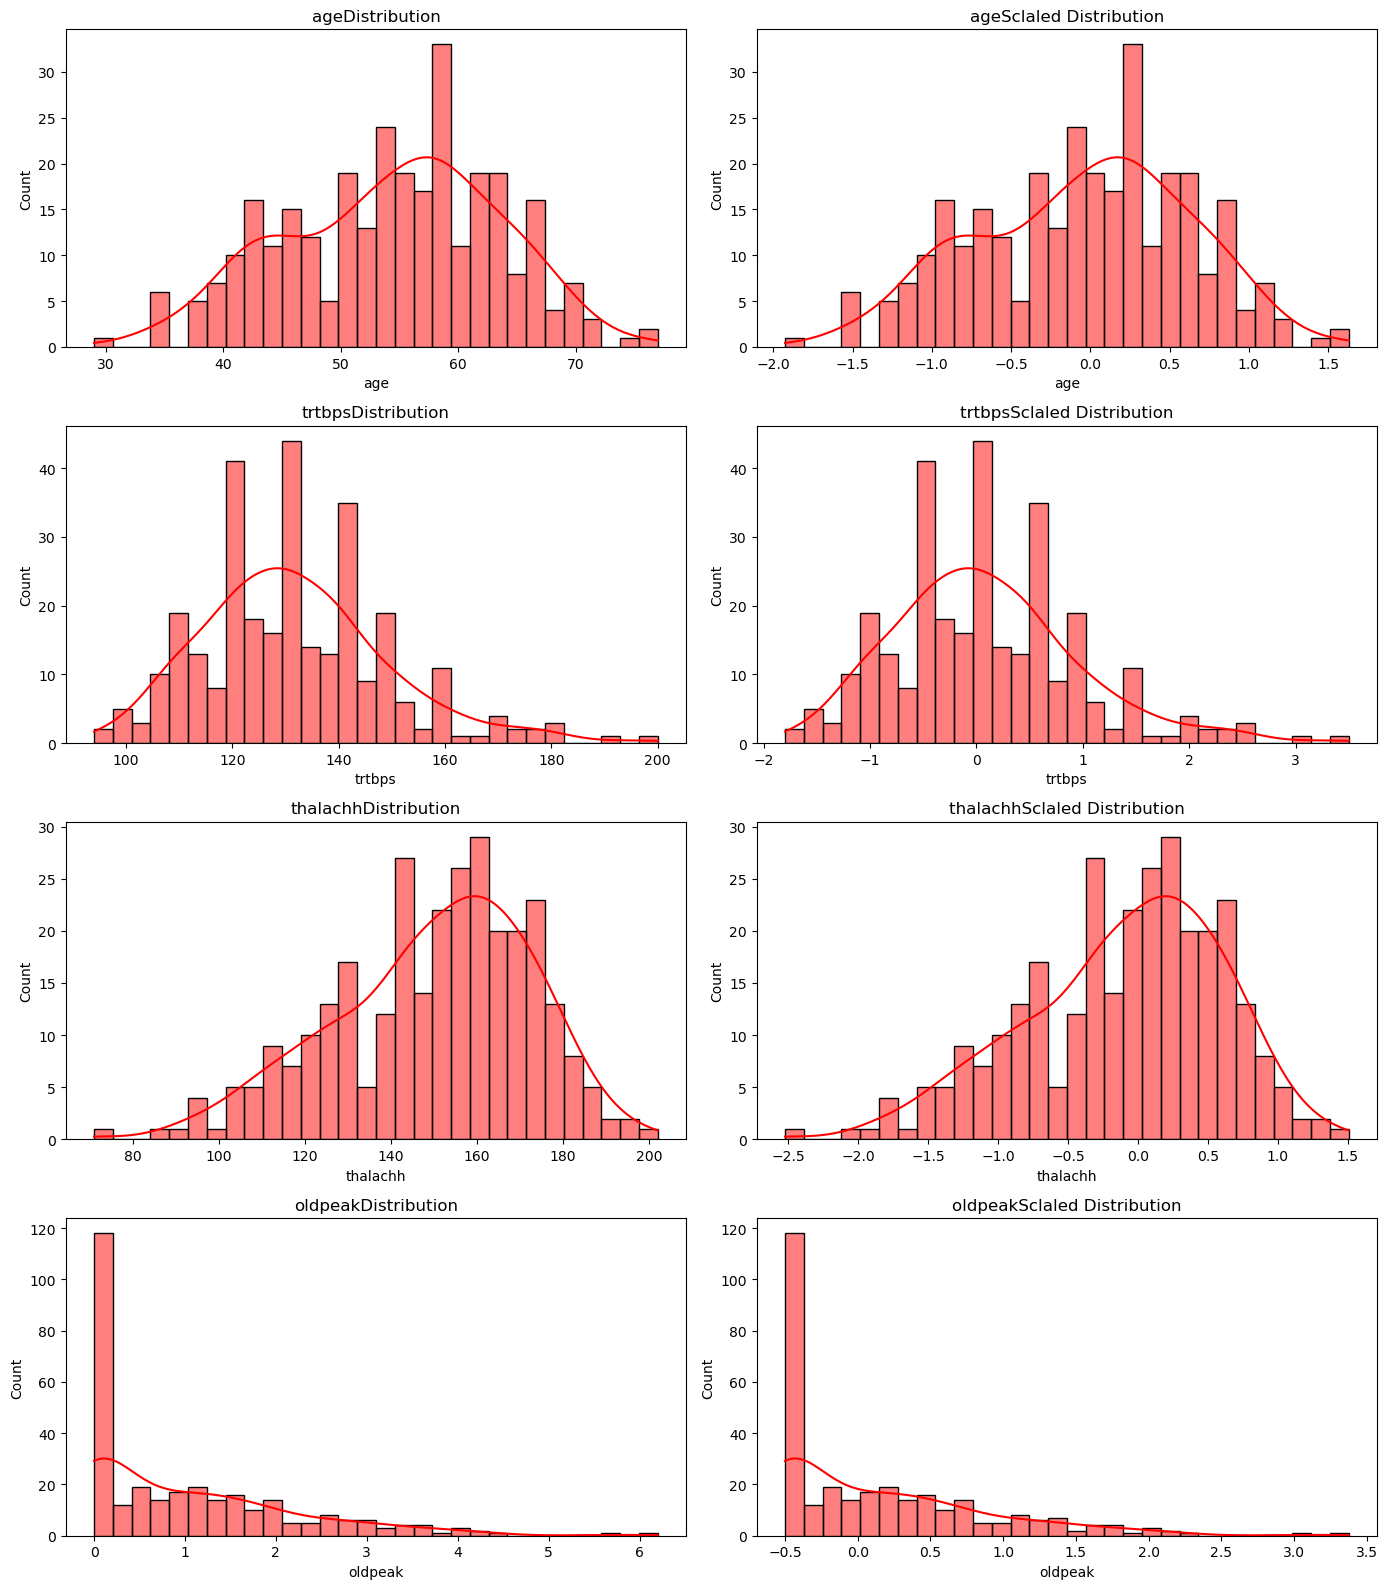

In [15]:
fig,ax = plt.subplots(len(num_cols),2,figsize = (14,len(num_cols)*4))

for idx,column in enumerate(num_cols):
    sns.histplot(x = column, data = data, bins = 30,kde = True,color = 'red',ax = ax[idx,0])
    ax[idx,0].set_title(f"{column}Distribution")

    sns.histplot(x = column, data = X, bins = 30,kde = True, color = 'red', ax = ax[idx,1])
    ax[idx,1].set_title(f"{column}Sclaled Distribution")

plt.tight_layout()
plt.show()



# 1. Logistic Regression



In [16]:
models = []
mean_auc = []
mean_precision = []
mean_recall = []
mean_f1 = []

log_accuracy = []
log_precision = []
log_recall = []
log_f1 = []
import time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.perf_counter()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'{" " * 13}{"#" * 24} Training FOLD {fold + 1} {"#" * 24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']}
    
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    log_best_params = grid_search.best_params_
    log_best_score = grid_search.best_score_
    
    model = grid_search.best_estimator_
    y_pred = model.predict(X_valid)
    accuracy = roc_auc_score(y_valid, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average='binary')
    
    log_accuracy.append(accuracy)
    log_precision.append(precision)
    log_recall.append(recall)
    log_f1.append(f1)

    print(f'AUC: {accuracy:.5f}{" "}Best Parameters: {log_best_params}{" "}Best Score: {log_best_score:.5f}{" "}Precision: {precision:.5f}{" "}Recall: {recall:.5f}{" "}F1-Score: {f1:.5f}')

    

end_time = time.perf_counter()
elapsed_time = end_time - start_time
mean_val_auc = np.mean(log_accuracy)
mean_val_precision = np.mean(log_precision)
mean_val_recall = np.mean(log_recall)
mean_val_f1 = np.mean(log_f1)
models.append('Logistic Regression')
mean_auc.append(mean_val_auc)
mean_precision.append(mean_val_precision)
mean_recall.append(mean_val_recall)
mean_f1.append(mean_val_f1)
print(f'{"*" * 92}')
print(f'Mean AUC: {mean_val_auc:.5f}{" " * 2}Mean Precision: {mean_val_precision:.3f}{" " * 2}Mean Recall: {mean_val_recall:.3f}{" " * 2}Mean F1-Score: {mean_val_f1:.3f}{" " * 2}Elapsed Time: {elapsed_time:.3f}s')    












             ######################## Training FOLD 1 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

AUC: 0.94118 Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.85630 Precision: 1.00000 Recall: 0.88235 F1-Score: 0.93750
             ######################## Training FOLD 2 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

AUC: 0.96429 Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} Best Score: 0.85266 Precision: 0.94444 Recall: 1.00000 F1-Score: 0.97143
             ######################## Training FOLD 3 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

AUC: 0.86975 Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.85286 Precision: 0.88235 Recall: 0.88235 F1-Score: 0.88235
             ######################## Training FOLD 4 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = 

AUC: 0.87330 Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.84606 Precision: 0.93333 Recall: 0.82353 F1-Score: 0.87500
             ######################## Training FOLD 5 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

AUC: 0.74887 Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.86431 Precision: 0.75000 Recall: 0.88235 F1-Score: 0.81081
             ######################## Training FOLD 6 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

AUC: 0.75446 Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} Best Score: 0.86795 Precision: 0.71429 Recall: 0.93750 F1-Score: 0.81081
             ######################## Training FOLD 7 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = 

AUC: 0.79464 Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'} Best Score: 0.84222 Precision: 0.77778 Recall: 0.87500 F1-Score: 0.82353
             ######################## Training FOLD 8 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

AUC: 0.79911 Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'} Best Score: 0.86047 Precision: 0.81250 Recall: 0.81250 F1-Score: 0.81250
             ######################## Training FOLD 9 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

AUC: 0.89286 Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.86431 Precision: 0.84211 Recall: 1.00000 F1-Score: 0.91429
             ######################## Training FOLD 10 ########################


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vec

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

AUC: 0.86607 Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'} Best Score: 0.85690 Precision: 0.87500 Recall: 0.87500 F1-Score: 0.87500
********************************************************************************************
Mean AUC: 0.85045  Mean Precision: 0.853  Mean Recall: 0.897  Mean F1-Score: 0.871  Elapsed Time: 16.724s


C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panse\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = 

                                                   BEST PARAMETER :-
        
 1. C : 10
 2. penalty : 12
 3. Solver : lbfgs
 
 

                                                     MEAN SCORE :-

*Mean AUC:
This is like an overall grade for the model, and it got a high score (0.85090). It means the model is really good at telling the difference between positive and negative instances.

*Precision:
The model is accurate when it says instance is positive. Scores between 0.714 and 1.000 mean it's doing well at not making mistakes when it claims something is positive.

*Recall:
The model is good at finding positive things in the data. Scores between 0.812 and 1.000 mean it's not missing many positive instances.

*F1-score: 
This is a combination of precision and recall, and scores between 0.810 and 0.971 mean the model is finding a good balance between being accurate and not missing important things.

*Consistency Across Folds:
Even though there are some small differences when looking at different parts of the data (folds), overall, the model is still very good at what it does.

Hence the model is reliable, accurate, and balanced in identifying positive instances, making it a solid choice for classification tasks.

C:\Users\panse\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


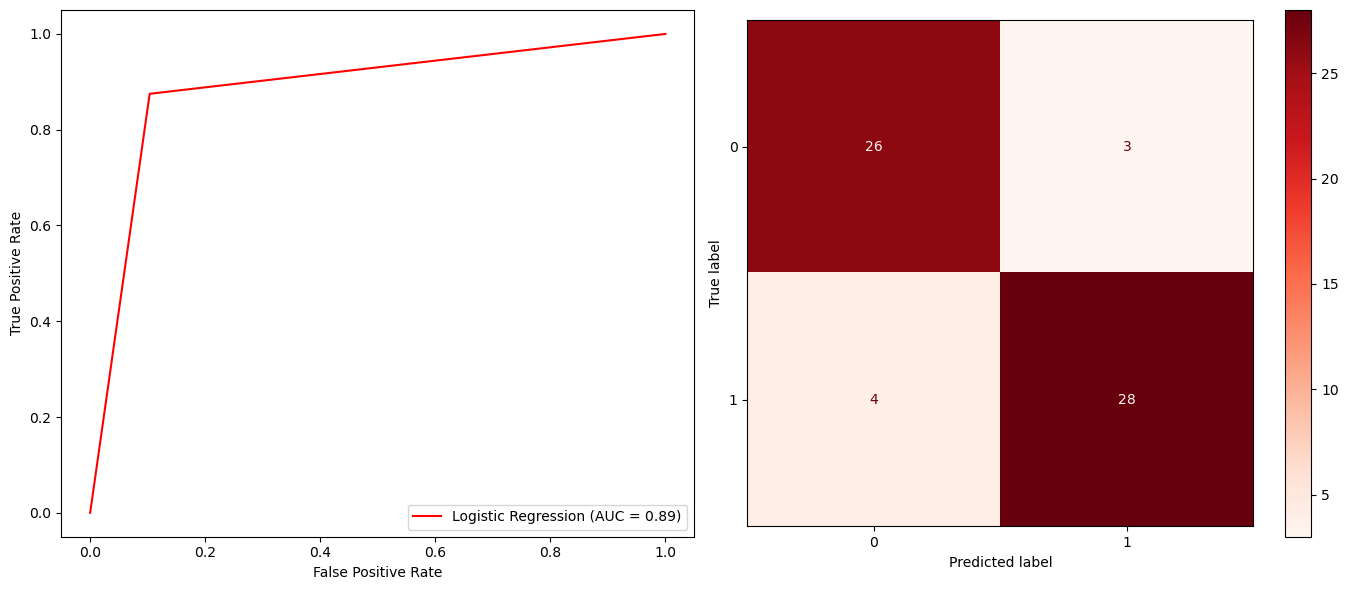

In [24]:
log = LogisticRegression(C=10, penalty='l2', solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
display.plot(color='red', ax=ax[0])
ConfusionMatrixDisplay.from_estimator(log, X_test, y_test, cmap='Reds', ax=ax[1])
plt.tight_layout()
plt.show()

                                               MODEL PERFORMANCE :-
True positives : 89.6% - 26

True negatives : 87.5% - 28

False positives : 10.4% - 3

False negatives : 12.5% - 4



The confusion matrix analysis shows that the model is pretty good at predicting both positive and negative cases. It gets about 89.6% of positive cases and 87.5% of negative cases right. This means the model is effective at identifying most of the positive and negative instances in the dataset. However, it's not perfect. There are still some mistakes. It wrongly predicts about 10.4% of cases as positive when they're not (false positives), and it misses about 12.5% of positive cases (false negatives). So, while it's doing well overall, it's not flawless and still makes some errors.

# 2.DECISION TREE

In [18]:
tree_accuracy = []
tree_precision = []
tree_recall = []
tree_f1 = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.perf_counter()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'{" " * 13}{"#" * 24} Training FOLD {fold + 1} {"#" * 24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    param_grid = {'max_depth': [3, 5, 7, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
    
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    tree_best_params = grid_search.best_params_
    tree_best_score = grid_search.best_score_
    
    model = grid_search.best_estimator_
    y_pred = model.predict(X_valid)
    accuracy = roc_auc_score(y_valid, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average='binary')
    
    tree_accuracy.append(accuracy)
    tree_precision.append(precision)
    tree_recall.append(recall)
    tree_f1.append(f1)
    
    print(f'AUC: {accuracy:.5f}{" "}Best Parameters: {tree_best_params}{" "}Best Score:{tree_best_score:.5f}{" "}Precision:{precision:.5f}{" "}Recall: {recall:.5f}{" "}F1-Score: {f1:.5f}')

end_time = time.perf_counter()   
elapsed_time = end_time - start_time
mean_val_auc = np.mean(tree_accuracy)
mean_val_precision = np.mean(tree_precision)
mean_val_recall = np.mean(tree_recall)
mean_val_f1 = np.mean(tree_f1)
models.append('Decision Tree')
mean_auc.append(mean_val_auc)
mean_precision.append(mean_val_precision)
mean_recall.append(mean_val_recall)
mean_f1.append(mean_val_f1)
print(f'{"*" * 92}')
print(f'Mean AUC: {mean_val_auc:.5f}{" " * 2}Mean Precision: {mean_val_precision:.3f}{" " * 2}Mean Recall: {mean_val_recall:.3f}{" " * 2}Mean F1-Score: {mean_val_f1:.3f}{" " * 2}Elapsed Time: {elapsed_time:.3f}s')

             ######################## Training FOLD 1 ########################
AUC: 0.84034 Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} Best Score:0.77172 Precision:0.87500 Recall: 0.82353 F1-Score: 0.84848
             ######################## Training FOLD 2 ########################
AUC: 0.83403 Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10} Best Score:0.73852 Precision:0.83333 Recall: 0.88235 F1-Score: 0.85714
             ######################## Training FOLD 3 ########################
AUC: 0.74580 Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10} Best Score:0.79044 Precision:0.80000 Recall: 0.70588 F1-Score: 0.75000
             ######################## Training FOLD 4 ########################
AUC: 0.76697 Best Parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2} Best Score:0.79098 Precision:0.81250 Recall: 0.76471 F1-Score: 0.78788
             #########

                                           Best parameters:-
1. Max depth: 3
2. Min Samples leaf:1 
2. Min Samples split:2
                                          
                                          
                                          Mean  Score:-
                                           

Mean AUC: 0.78047 represents a moderately good performance, where a value of 1 indicates perfect performance and 0.5 represents random chance. It signifies the model's ability to distinguish between positive and negative cases.

Mean Precision: 0.789 indicates that out of 100 positive predictions made by the model, 79 were actually correct. In other words, the model has a relatively low false positive rate, meaning it doesn't often mistake negative cases as positive.

Mean Recall: 0.837 suggests that out of 100 actual positive cases, the model was able to correctly identify 84. This implies a good ability to capture true positives, with a low chance of missing them.

Mean F1-Score: 0.809 combines precision and recall into a single metric, providing a balanced view of the model's performance. A score of 0.8 indicates a good balance between precision and recall.

Overall, these metrics suggest that the model performs moderately well, with a good balance between identifying true positives and avoiding false positives.
                                           



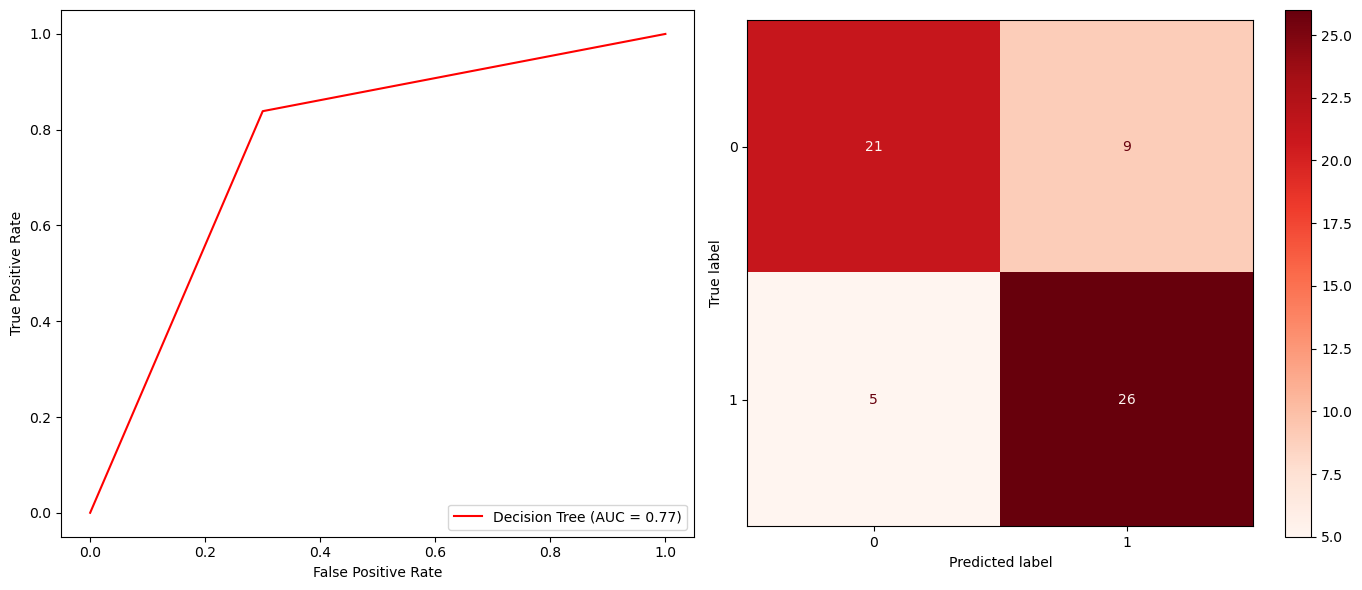

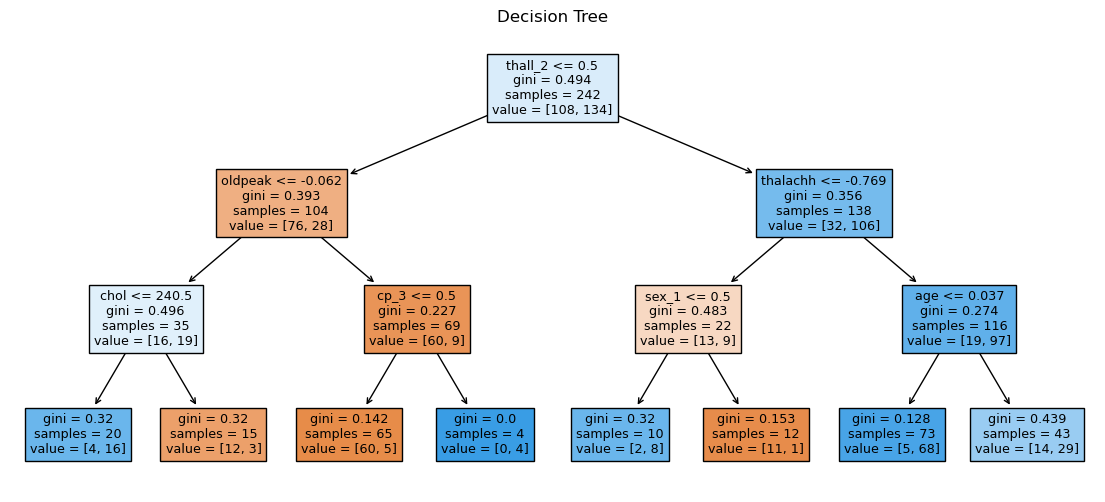

In [23]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
display.plot(color='red', ax=ax[0])
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap='Reds', ax=ax[1])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
ax = plot_tree(tree, feature_names=X.columns.to_list(), filled=True)
plt.title('Decision Tree', )
plt.show()

                                               Model Performance


True positives (70% - 21): 

True negatives (83.8% - 26): 

False positives (30% - 9): 

False negatives (16.2% - 5): 


The model's performance shows concerns in accurately predicting both positive and negative instances. It correctly identifies positive cases 70% of the time and negative cases 83.8% of the time. However, it tends to misclassify positive instances as negative (30% false positives) and negative instances as positive (16.2% false negatives) more often than desired. This raises the risk of the model providing misleading results and affecting its overall effectiveness. Hence model performance metrics indicate that there might be some issues with the model's ability to accurately predict both positive and negative instances.